In [70]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator
load_dotenv()

True

In [71]:
generator_llm = ChatOpenAI(model = 'gpt-3.5-turbo')
evaluator_llm = ChatOpenAI(model = 'gpt-4o-mini')
optimizer_llm = ChatOpenAI(model='gpt-4o')

In [72]:
class TweetEvaluation(BaseModel):

    evaluation: Literal['approved', 'needs_improvement'] = Field(..., description="Final evaluatoin results.")
    feedback: str = Field(..., description="Constructive feedback for this tweet.")

In [73]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [74]:
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal['approved', 'needs_improvement']
    feedback: str
    iteration: int
    max_iteration: int


    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [75]:
def generate_tweet(state: TweetState):
     

    # create prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
        Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

        Rules:
        - Do NOT use question-answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarcasm, or cultural references.
        - Think in meme logic, punchlines, or relatable takes.
        - Use simple, day to day english
""")
    ]
    # send that prompt to generator llm

    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [76]:
def evaluate_tweet(state: TweetState):
    
    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
    Evaluate the following tweet:

    Tweet: "{state['tweet']}"

    Use the criteria below to evaluate the tweet:

    1. Originality – Is this fresh, or have you seen it a hundred times before?  
    2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
    3. Punchiness – Is it short, sharp, and scroll-stopping?  
    4. Virality Potential – Would people retweet or share it?  
    5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

    Auto-reject if:
    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
    - It exceeds 280 characters
    - It reads like a traditional setup-punchline joke
    - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

    ### Respond ONLY in structured format:
    - evaluation: "approved" or "needs_improvement"  
    - feedback: One paragraph explaining the strengths and weaknesses 
    """)
    ]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation': response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [92]:
def optimize_tweet(state: TweetState):
    
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
    Improve the tweet based on this feedback:
    "{state['feedback']}"

    Topic: "{state['topic']}"
    Original Tweet:
    {state['tweet']}

    Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
    """)
        ]
    
    response = optimizer_llm.invoke(messages).content
    iteration = state['iteratoin'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}


In [100]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [94]:
graph = StateGraph(TweetState)


graph.add_node('geneate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)


# create an edges of the nodes
graph.add_edge(START, 'geneate')
graph.add_edge('geneate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'geneate')

workflow = graph.compile()

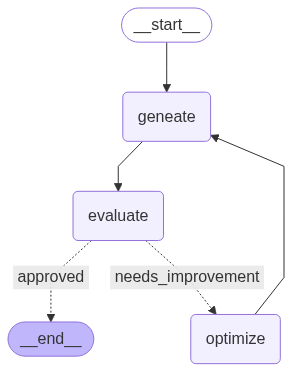

In [95]:
workflow

In [99]:
initial_state = {
    'topic': 'Pakistani Technology Industry',
    'iteration': 1,
    'max_iterations': 5

}

result = workflow.invoke(initial_state)

result

{'topic': 'Pakistani Technology Industry',
 'tweet': '"Trying to keep up with the Pakistani technology industry is like trying to update your phone in the middle of load shedding - constantly in the dark and never quite getting there. #TechStruggles"',
 'evaluation': 'approved',
 'feedback': "This tweet scores well on originality, as the comparison made about trying to keep up with the Pakistani technology industry and load shedding presents a unique cultural insight that many can relate to. The humor is effective, cleverly highlighting the frustration that comes with both situations, which adds a relatable twist. The punchiness is decent; while it's a bit longer than some might prefer, it's still engaging enough to catch attention. The potential for virality is high due to its cultural specificity and relatability among those familiar with these experiences. The format is appropriate, following the standard tweet structure without unnecessary complications.",
 'iteration': 1,
 'tweet_